# Final Project: NYC Apartment Search

## Setup

In [1]:
# Import packages needed for the project

import json
import pathlib
import urllib.parse

import geoalchemy2 as gdb
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import requests
import shapely
import sqlalchemy as db

import psycopg2
from datetime import datetime
from sqlalchemy.orm import declarative_base

## Part 1: Data Preprocessing

In [2]:
# Datafile and path
DATA_DIR = pathlib.Path("data")
ZIPCODE_DATA_FILE = DATA_DIR / "zipcodes" / "nyc_zipcodes.shp"
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"

### 1.1 Zipcode Data

In [3]:
def load_and_clean_zipcodes(zipcode_datafile):
    """
    Return a geodataframe.
    
    Keyword arguments:
    zipcode_datafile -- a shape file that contains geometry data
    """
    
    # load data
    df = gpd.read_file(zipcode_datafile)
     
    # Select needed columns
    clean_columns = ['ZIPCODE','geometry']
    df = df[clean_columns]
    
    # Remove invalid data points by rows
    df = df.dropna()
    
    # remove duplicate zip codes
    df.drop_duplicates(subset='ZIPCODE', keep='first', inplace=True)
    
    # Normalize column names
    df.columns = df.columns.str.lower()
    df.rename(columns={'zipcode': 'zip_code'}, inplace=True)

    # Normalize SRID
    df['geometry'] = df['geometry'].to_crs("epsg:4326")
    
    return df


In [4]:
geodf_zipcode_data = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)

In [5]:
geodf_zipcode_data

,zip_code,geometry
0,11436,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,11212,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,11225,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,11218,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."
...,...,...
257,11414,"POLYGON ((-73.85068 40.67165, -73.84995 40.671..."
258,10310,"POLYGON ((-74.12065 40.64104, -74.12057 40.641..."
260,11249,"POLYGON ((-73.95805 40.72442, -73.95772 40.724..."
261,10162,"POLYGON ((-73.95133 40.76931, -73.95165 40.769..."


### 1.2 NYC Open Data: 311 Service Requests Data

In [6]:
def download_and_clean_311_data():
    """
    Download and clean 311 service data, and return a geodataframe.
    """
    
    ### (1)Download the data
    # Set up the url obtained the data from
    url = "https://data.cityofnewyork.us/resource/erm2-nwe9.geojson"
    
    # Select the needed columns to download
    column_select = "?$select=created_date,incident_zip,complaint_type,location"
    url_column = url+column_select
    
    # Set up the headers to pass the application token
    header = {"X-App-Token": "oOu0LSU0TAyxOY44hvVXEv2hT"}

    # Set up the parameter to limit the number of rows and date range
    param = {"$limit": 25000000,
            } 

    # Make the API request and download the geojson file to local
    response = requests.get(url_column, headers=header, params=param)
    
    with open("data/nyc_311.geojson", "wb") as file:
        file.write(response.content)
    
    df = gpd.read_file("data/nyc_311.geojson")
                       
    ### (2)Clean the data
    # Remove invalid data by rows
    df.dropna(inplace=True)
    
    # Normalize column names and types if needed
    df.rename(columns={'incident_zip': 'zip_code'}, inplace=True)
    df['zip_code'] = df['zip_code'].astype("string")
    df['created_date'] = df['created_date'].dt.date
    
    # Normalize SRID
    df['geometry'] = df['geometry'].to_crs("epsg:4326")

                       
    return df

In [7]:
geodf_311_data = download_and_clean_311_data()

In [8]:
geodf_311_data

,created_date,zip_code,complaint_type,geometry
0,2023-12-09,11412,Derelict Vehicles,POINT (-73.75719 40.69898)
1,2023-12-09,11357,Derelict Vehicles,POINT (-73.82518 40.77956)
2,2023-12-09,11222,Derelict Vehicles,POINT (-73.94549 40.71914)
3,2023-12-09,10032,Graffiti,POINT (-73.94337 40.83670)
4,2023-12-09,11211,Graffiti,POINT (-73.95151 40.71341)
...,...,...,...,...
24999995,2014-12-31,10040,HEAT/HOT WATER,POINT (-73.92715 40.86194)
24999996,2014-12-31,10032,HEAT/HOT WATER,POINT (-73.94096 40.82924)
24999997,2014-12-31,11225,HEAT/HOT WATER,POINT (-73.95811 40.66112)
24999998,2014-12-31,10457,PLUMBING,POINT (-73.89439 40.84814)


### 1.3 NYC Open Data: Tree Data

In [9]:
def download_and_clean_tree_data():
    """
    Download and clean tree data, and return a geodataframe.
    """
    
    ### (1)Download the data
    # Set up the url obtained the data from
    url = "https://data.cityofnewyork.us/resource/5rq2-4hqu.geojson"

    # Set up the headers to pass the application token
    header = {"X-App-Token": "oOu0LSU0TAyxOY44hvVXEv2hT"}

    # Set up the parameter to limit the number of rows
    param = {"$limit": 684000} 

    # Make the API request and converting the JSON response to obtain a dataframe
    response = requests.get(url,headers=header, params=param)
    
    with open("data/tree.geojson", "wb") as file:
        file.write(response.content)
        
    df = gpd.read_file("data/tree.geojson")
    
    ### (2)Clean the data
    # Select necessary columns and Remove the others
    clean_columns = ['tree_id','created_at','zipcode','spc_common','health','status','geometry']
    df = df[clean_columns]

    
    # Remove invalid data by rows
    df.dropna(inplace=True)
    
    # Normalize column names and types if needed
    df.rename(columns={'zipcode': 'zip_code'}, inplace=True)
    df.rename(columns={'spc_common': 'species'}, inplace=True)
    df.rename(columns={'created_at': 'created_date'}, inplace=True)
    pd.to_datetime(df['created_date'], format='%m/%d/%Y').dt.date
    
    df['geometry'] = df['geometry'].to_crs("epsg:4326")
    
    
    return df

In [10]:
geodf_tree_data = download_and_clean_tree_data()

In [11]:
geodf_tree_data

,tree_id,created_date,zip_code,species,health,status,geometry
0,180683,08/27/2015,11375,red maple,Fair,Alive,POINT (-73.84422 40.72309)
1,200540,09/03/2015,11357,pin oak,Fair,Alive,POINT (-73.81868 40.79411)
2,204026,09/05/2015,11211,honeylocust,Good,Alive,POINT (-73.93661 40.71758)
3,204337,09/05/2015,11211,honeylocust,Good,Alive,POINT (-73.93446 40.71354)
4,189565,08/30/2015,11215,American linden,Good,Alive,POINT (-73.97598 40.66678)
...,...,...,...,...,...,...,...
683783,155433,08/18/2015,11211,pin oak,Good,Alive,POINT (-73.95494 40.71321)
683784,183795,08/29/2015,11375,Kentucky yellowwood,Good,Alive,POINT (-73.85665 40.71519)
683785,166161,08/22/2015,10314,red maple,Good,Alive,POINT (-74.13652 40.62076)
683786,184028,08/29/2015,10457,red maple,Good,Alive,POINT (-73.90311 40.85083)


### 1.4 Zillow Rent Data

In [12]:
def load_and_clean_zillow_data():
    """
    Load and clean the Zillow rent data, and return a dataframe.
    """
    
    # load the csv file
    df = pd.read_csv(ZILLOW_DATA_FILE)
    
    # Filter out non-NYC cities
    df = df[df['City']=='New York']

    # Remove unused columns
    df.drop(columns=['RegionID', 'SizeRank','RegionType','StateName','State','City','Metro','CountyName'],inplace=True)
    
    # Normalize column names used later
    df.columns = df.columns.str.lower()
    df.rename(columns={'regionname': 'zip_code'}, inplace=True)
    df.rename(columns={'2023-09-30': 'september2023'}, inplace=True)
    df.rename(columns={'2023-08-31': 'august2023'}, inplace=True)
    df.rename(columns={'2023-01-31': 'january2023'}, inplace=True)

    # Normalize the column types
    for col in df.columns:
        if col != 'zip_code':
            df[col] = pd.to_numeric(df[col])
    df['zip_code'] = df['zip_code'].astype("string")
    df1 = df.copy()
    
    # Add a new column 'mean' which computes the average rent for each zipcode within the timeframe for Part 4
    df1['mean'] = df1.iloc[:, 1:].mean(axis=1, skipna=True)
    
    # Select necessary columns
    clean_columns = ['zip_code','january2023','august2023','september2023','mean']# we will round the price in sql
    df1 = df1[clean_columns]
    
    # Remove invalid data by rows
    df1.iloc[:,1:] = df1.iloc[:,1:].fillna(df.iloc[:,1:].mean())
    
    return df1

In [13]:
df_zillow_data=load_and_clean_zillow_data()

In [14]:
df_zillow_data

,zip_code,january2023,august2023,september2023,mean
4,11385,2895.699421,3064.476503,3079.585783,2476.923402
6,11208,2588.030194,2737.547470,2728.733333,2560.469803
12,11236,3029.546370,2285.460026,2362.500000,2323.980013
13,10467,2155.617718,2353.686402,2423.888889,1861.072982
14,11373,2255.604528,2302.557354,2292.994444,2084.549636
...,...,...,...,...,...
6550,10282,7143.347680,7444.236260,7347.458333,7029.339124
6561,11109,4159.759749,4490.367074,4529.358974,3518.929190
6644,10006,3747.416799,4042.831474,4060.096154,3489.762997
6695,10162,3029.546370,4984.693932,5011.666667,4968.739544


### 1.5 Overview of Datasets

In [15]:
# Show basic info about each dataframe
geodf_zipcode_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 248 entries, 0 to 262
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zip_code  248 non-null    object  
 1   geometry  248 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 5.8+ KB


In [16]:
# Show first 5 entries about each dataframe
geodf_zipcode_data.geometry

0      POLYGON ((-73.80585 40.68291, -73.80569 40.682...
1      POLYGON ((-73.93740 40.67973, -73.93487 40.679...
2      POLYGON ((-73.90294 40.67084, -73.90223 40.668...
3      POLYGON ((-73.95797 40.67066, -73.95576 40.670...
4      POLYGON ((-73.97208 40.65060, -73.97192 40.650...
                             ...                        
257    POLYGON ((-73.85068 40.67165, -73.84995 40.671...
258    POLYGON ((-74.12065 40.64104, -74.12057 40.641...
260    POLYGON ((-73.95805 40.72442, -73.95772 40.724...
261    POLYGON ((-73.95133 40.76931, -73.95165 40.769...
262    POLYGON ((-73.99354 40.75145, -73.99320 40.751...
Name: geometry, Length: 248, dtype: geometry

In [17]:
geodf_311_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 23680458 entries, 0 to 24999999
Data columns (total 4 columns):
 #   Column          Dtype   
---  ------          -----   
 0   created_date    object  
 1   zip_code        string  
 2   complaint_type  object  
 3   geometry        geometry
dtypes: geometry(1), object(2), string(1)
memory usage: 903.3+ MB


In [18]:
geodf_311_data.head()

,created_date,zip_code,complaint_type,geometry
0,2023-12-09,11412,Derelict Vehicles,POINT (-73.75719 40.69898)
1,2023-12-09,11357,Derelict Vehicles,POINT (-73.82518 40.77956)
2,2023-12-09,11222,Derelict Vehicles,POINT (-73.94549 40.71914)
3,2023-12-09,10032,Graffiti,POINT (-73.94337 40.83670)
4,2023-12-09,11211,Graffiti,POINT (-73.95151 40.71341)


In [19]:
geodf_tree_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 652167 entries, 0 to 683787
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   tree_id       652167 non-null  object  
 1   created_date  652167 non-null  object  
 2   zip_code      652167 non-null  object  
 3   species       652167 non-null  object  
 4   health        652167 non-null  object  
 5   status        652167 non-null  object  
 6   geometry      652167 non-null  geometry
dtypes: geometry(1), object(6)
memory usage: 39.8+ MB


In [20]:
geodf_tree_data.head()

,tree_id,created_date,zip_code,species,health,status,geometry
0,180683,08/27/2015,11375,red maple,Fair,Alive,POINT (-73.84422 40.72309)
1,200540,09/03/2015,11357,pin oak,Fair,Alive,POINT (-73.81868 40.79411)
2,204026,09/05/2015,11211,honeylocust,Good,Alive,POINT (-73.93661 40.71758)
3,204337,09/05/2015,11211,honeylocust,Good,Alive,POINT (-73.93446 40.71354)
4,189565,08/30/2015,11215,American linden,Good,Alive,POINT (-73.97598 40.66678)


In [21]:
df_zillow_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145 entries, 4 to 6721
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   zip_code       145 non-null    string 
 1   january2023    145 non-null    float64
 2   august2023     145 non-null    float64
 3   september2023  145 non-null    float64
 4   mean           145 non-null    float64
dtypes: float64(4), string(1)
memory usage: 6.8 KB


In [92]:
df_zillow_data.head()

,zip_code,january2023,august2023,september2023,mean
4,11385,2895.699421,3064.476503,3079.585783,2476.923402
6,11208,2588.030194,2737.547470,2728.733333,2560.469803
12,11236,3029.546370,2285.460026,2362.500000,2323.980013
13,10467,2155.617718,2353.686402,2423.888889,1861.072982
14,11373,2255.604528,2302.557354,2292.994444,2084.549636


## Part 2: Storing Data

In [23]:
# Assign database name,user,url,and schema
DB_NAME = "Final_Project"
DB_USER = "postgres"
DB_URL = f"postgresql+psycopg2://{DB_USER}@localhost/{DB_NAME}"
DB_SCHEMA_FILE = "schema.sql"

### 2.1 Creating Database

In [24]:
def setup_new_postgis_database(username, db_name):
    """
    Form and return a connection to the database Final_Project.
    
    Keyword arguments:
    username -- the username for the connection, which will be postgres
    db_name  -- the databse name for the connection, which will be Final_Project
    """
    conn = psycopg2.connect(dbname=db_name, user=username)
    return conn

In [25]:
setup_new_postgis_database(DB_USER, DB_NAME)

<connection object at 0x156e874c0; dsn: 'dbname=Final_Project user=postgres', closed: 0>

### 2.2 Creating Tables

In [26]:
engine = db.create_engine(DB_URL)

In [27]:
ZIPCODE_SCHEMA = """
CREATE TABLE IF NOT EXISTS zipcodes
(
    id INTEGER PRIMARY KEY,
    zip_code CHAR(5),
    geometry GEOMETRY(Polygon,4326)
)
"""

NYC_311_SCHEMA = """
CREATE TABLE IF NOT EXISTS complaints
(
    id INTEGER PRIMARY KEY,
    created_date DATE,
    zip_code CHAR(5),
    complaint_type TEXT,
    geometry GEOMETRY(Point,4326)
)
"""
    
NYC_TREE_SCHEMA = """
CREATE TABLE IF NOT EXISTS trees
(
    id INTEGER PRIMARY KEY,
    tree_id INTEGER,
    created_date DATE,
    zip_code CHAR(5),
    species TEXT,
    health TEXT,
    status TEXT,
    geometry GEOMETRY(Point,4326)
)
"""


ZILLOW_SCHEMA = """
CREATE TABLE IF NOT EXISTS rents
(
    id INTEGER PRIMARY KEY,
    zip_code CHAR(5),
    january2023 FLOAT,
    august2023 FLOAT,
    september2023 FLOAT,
    mean FLOAT
)
"""

In [28]:
# Write the queries schema to the schema file
with open(DB_SCHEMA_FILE, "w") as f:
    f.write(ZIPCODE_SCHEMA + ";\n")
    f.write(NYC_311_SCHEMA + ";\n")
    f.write(NYC_TREE_SCHEMA + ";\n")
    f.write(ZILLOW_SCHEMA + ";\n")

In [29]:
# Execute the schema files to create tables
with engine.connect() as connection:
    connection.execute(open(DB_SCHEMA_FILE, "r").read())

### 2.3 Add Data to Database

In [30]:
def write_dataframes_to_table(tablename_to_dataframe):
    """
    Add data to their respective table.
    
    Keyword arguments:
    tablename_to_dataframe -- a dictionary having table name as the key and data as the value
    """
    
    for table, df in tablename_to_dataframe.items():
        # Add data to table with geospatial data
        if isinstance(df, gpd.GeoDataFrame):
            df.to_postgis(table, con=engine, if_exists='replace', index=False)
            
        # Add data to table without geospatial data
        else:
            df.to_sql(table, con=engine, if_exists='replace', index=False)

In [31]:
tablename_to_dataframe = {
    "zipcodes": geodf_zipcode_data,
    "complaints": geodf_311_data,
    "trees": geodf_tree_data,
    "rents": df_zillow_data,
}

In [32]:
write_dataframes_to_table(tablename_to_dataframe)

## Part 3: Understanding the Data

In [34]:
# Make directory where Database queries 3 will be saved
QUERY_DIR = pathlib.Path("queries")

# Make sure the QUERY_DIRECTORY exists
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir()

In [35]:
def write_query_to_file(query, outfile):
    """
    Write the queries to file.
    """
    with open(outfile, 'w') as file:
        file.write(query)

### Query 1

In [36]:
QUERY_1_FILENAME = QUERY_DIR / "Area_By_Complaints"

QUERY_1 = """
SELECT
    zip_code,
    COUNT(*) AS num_complaints
FROM
    complaints
WHERE
    created_date BETWEEN '2022-10-01' AND '2023-09-30'
GROUP BY
    zip_code
ORDER BY
    num_complaints DESC
"""

In [37]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

In [38]:
# Check Query 1
with engine.connect() as connection:
    df = pd.read_sql_query(QUERY_1, connection)
df

,zip_code,num_complaints
0,11226,49283
1,10467,47364
2,10468,44046
3,10452,43858
4,11385,43588
...,...,...
237,10175,1
238,10550,1
239,10080,1
240,29601,1


### Query 2

In [39]:
QUERY_2_FILENAME = QUERY_DIR / "Top10_Greenery"

QUERY_2 = """
SELECT
    zip_code,
    COUNT(*) AS num_trees
FROM
    trees
GROUP BY
    zip_code
ORDER BY
    num_trees DESC
LIMIT 10
"""

In [40]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

In [41]:
# Able to delete later
with engine.connect() as connection:
    df = pd.read_sql_query(QUERY_2, connection)
df

,zip_code,num_trees
0,10312,21356
1,10314,16330
2,10306,12616
3,10309,12105
4,11234,10838
5,11385,10262
6,11357,9016
7,11207,8293
8,11208,7896
9,11434,7833


### Query 3

In [42]:
QUERY_3_FILENAME = QUERY_DIR / "Top10_Greenery_Rent"

QUERY_3 = """
SELECT 
    top10trees.zip_code,
    ROUND(CAST(rents.august2023 AS numeric),2) AS average_rent
FROM (
    SELECT zip_code,COUNT(*) AS num_trees
    FROM trees
    GROUP BY zip_code
    ORDER BY num_trees DESC
    LIMIT 10
    )as top10trees
JOIN 
    rents ON top10trees.zip_code = rents.zip_code
ORDER BY 
    top10trees.num_trees DESC
"""

In [43]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

In [44]:
with engine.connect() as connection:
    df = pd.read_sql_query(QUERY_3, connection)
df

,zip_code,average_rent
0,10312,1775.09
1,10314,2465.47
2,10306,2331.54
3,10309,1832.01
4,11234,2312.31
5,11385,3064.48
6,11357,2458.81
7,11207,3079.09
8,11208,2737.55
9,11434,2645.92


### Query 4

In [45]:
QUERY_4_FILENAME = QUERY_DIR / "Rent_Tree_Complaint"

QUERY_4 =  """
SELECT 
    rent_low.zip_code, 
    rent_low.average_rent, 
    tree_count.num_trees AS num_trees,
    complaint_count.num_complaints AS num_complaints
FROM(
    SELECT zip_code, ROUND(CAST(january2023 AS numeric),2) as average_rent
    FROM rents
    ORDER BY average_rent ASC
    LIMIT 5
    ) AS rent_low
LEFT JOIN (
    SELECT zip_code, COUNT(*) AS num_trees
    FROM trees
    GROUP BY zip_code
    ) AS tree_count ON rent_low.zip_code = tree_count.zip_code  
LEFT JOIN (
    SELECT zip_code, COUNT(*) AS num_complaints
    FROM complaints
    GROUP BY zip_code
    ) AS complaint_count ON rent_low.zip_code = complaint_count.zip_code

UNION ALL
    
SELECT 
    rent_low.zip_code, 
    rent_low.average_rent, 
    COALESCE(tree_count.num_trees, 0) AS num_trees,
    COALESCE(complaint_count.num_complaints, 0) AS num_complaints
FROM(
    SELECT zip_code, ROUND(CAST(january2023 AS numeric),2) as average_rent
    FROM rents
    ORDER BY average_rent DESC
    LIMIT 5
    ) AS rent_low
LEFT JOIN (
    SELECT zip_code, COUNT(*) AS num_trees
    FROM trees
    GROUP BY zip_code
    ) AS tree_count ON rent_low.zip_code = tree_count.zip_code  
LEFT JOIN (
    SELECT zip_code, COUNT(*) AS num_complaints
    FROM complaints
    GROUP BY zip_code
    ) AS complaint_count ON rent_low.zip_code = complaint_count.zip_code
    
ORDER BY average_rent
    
"""
    

In [46]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

In [47]:
with engine.connect() as connection:
    df = pd.read_sql_query(QUERY_4, connection)
df

,zip_code,average_rent,num_trees,num_complaints
0,10309,1380.51,12105,81235
1,10462,1801.89,4048,213711
2,10453,1820.23,2874,296879
3,11357,1829.66,9016,100972
4,10458,1883.08,3212,292113
5,10011,4741.87,2040,157353
6,10069,4959.67,112,4155
7,10013,5480.11,1132,100555
8,10282,7143.35,230,4847
9,10007,7270.24,338,32268


### Query 5

In [48]:
QUERY_5_FILENAME = QUERY_DIR / "Greenery_Geometry"

QUERY_5 =  """
SELECT trees.zip_code, COUNT(*) AS num_trees
FROM trees
JOIN zipcodes ON ST_Contains(zipcodes.geometry, trees.geometry)
GROUP BY trees.zip_code
ORDER BY num_trees DESC
LIMIT 10
"""

In [49]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

In [50]:
with engine.connect() as connection:
    df = pd.read_sql_query(QUERY_5, connection)
df

,zip_code,num_trees
0,10312,21356
1,10314,16330
2,10306,12616
3,10309,12105
4,11234,10838
5,11385,10262
6,11357,9016
7,11207,8293
8,11208,7896
9,11434,7833


### Query 6

In [51]:
latitude = 40.80737875669467
longitude = -73.96253174434912
radius = 1/2 * 1609.34

QUERY_6_FILENAME = QUERY_DIR / "Area_Geometry"

QUERY_6 = f"""
SELECT
    tree_id,
    species,
    health,
    status,
    ST_AsText(ST_GeomFromWKB(geometry)) as coordinate_location 
FROM trees
WHERE     
    ST_DistanceSphere(
    ST_GeomFromText('POINT({longitude} {latitude})',4326),
    trees.geometry) <= {radius}
"""


In [52]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

In [53]:
with engine.connect() as connection:
    df = pd.read_sql_query(QUERY_6, connection)
df

,tree_id,species,health,status,coordinate_location
0,198514,pin oak,Good,Alive,POINT(-73.96207980385901 40.80230108588602)
1,209919,London planetree,Good,Alive,POINT(-73.96331506361766 40.808811547267055)
2,209921,London planetree,Good,Alive,POINT(-73.96340334087577 40.80874458097537)
3,203887,willow oak,Good,Alive,POINT(-73.96071917063361 40.805725833688264)
4,196440,American elm,Fair,Alive,POINT(-73.96412322243684 40.81114537770991)
...,...,...,...,...,...
2773,198508,pin oak,Good,Alive,POINT(-73.96290465467908 40.80264795359271)
2774,187144,pin oak,Good,Alive,POINT(-73.96190643162898 40.80582817754477)
2775,187101,pin oak,Good,Alive,POINT(-73.96249825252751 40.80502140068946)
2776,203997,London planetree,Good,Alive,POINT(-73.96065410755823 40.80499023931206)


## Part 4: Visualizing the Data

### Visualization 1

In [54]:
def get_data_for_visual_1():
    """ 
    Write a query to get data from database for Visualization 1 and return to a dataframe.
    """
    
    QUERY_Visual1 = """
        SELECT top3.complaint_type as type, DATE(complaints.created_date) as date, COUNT(*)
        FROM(
            SELECT complaint_type
            FROM complaints
            WHERE created_date BETWEEN '2022-10-01' AND '2023-12-30'
            GROUP BY complaint_type
            ORDER BY COUNT(*) DESC
            LIMIT 3)
        AS top3
        LEFT JOIN complaints ON top3.complaint_type = complaints.complaint_type
        GROUP BY type,date
        ORDER BY date
        """
    
    with engine.connect() as connection:
        df = pd.read_sql_query(QUERY_Visual1, connection)
        
    return df

In [72]:
def plot_visual_1(df):
    """Plot a line graph for each of the top 3 complaint type between 10/1/2022 and 9/30/2023.
    
    Keyword arguments:
    df -- a dataframe contains the top 3 complaint type and number of each type in each day
    """

    complaints = df['type'].unique() # Get name of the top3 complaint type
    complaints = complaints.tolist() # convert the numpy array to list
    
    # store each name
    cpl1 = complaints[0] 
    cpl2 = complaints[1]
    cpl3 = complaints[2]
    
    # seperate the dataframe by name 
    cpls1 = df[df['type'] == cpl1]
    cpls2 = df[df['type'] == cpl2]
    cpls3 = df[df['type'] == cpl3]
    
    # draw the line graph for the first complaint type
    plt.plot(cpls3['date'], cpls3['count'], label=f'{cpl3}', marker='None', linestyle='-.')

    # draw the line graph for the second complaint type
    plt.plot(cpls2['date'], cpls2['count'], label=f'{cpl2}', marker='None', linestyle='--')

    # draw the line graph for the third complaint type
    plt.plot(cpls1['date'], cpls1['count'], label=f'{cpl1}', marker='None', linestyle='-')
    
    plt.legend()  
    plt.title('Number of Top 3 Complaints in Each Day')
    plt.xlabel('Date')  
    plt.ylabel('Number of Complaints')
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()

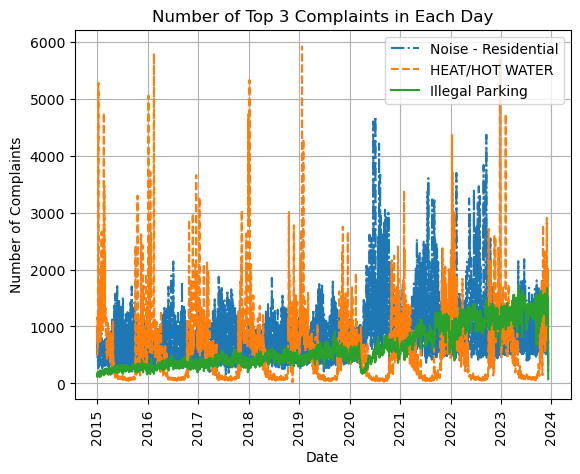

In [73]:
df_visual1 = get_data_for_visual_1()
plot_visual_1(df_visual1)

### Visualization 2

In [74]:
def get_data_for_visual_2():
    """ 
    Write a query to get data from database for Visualization 2 and return to a dataframe.
    """
    
    QUERY_Visual2 = """
    SELECT complaint_type,COUNT(*) AS num_complaints
    FROM complaints
    WHERE (created_date BETWEEN '2018-10-01' AND '2023-12-09')
    AND zip_code = '10027'
    GROUP BY complaint_type
    ORDER BY num_complaints DESC
    LIMIT 10
    """
    
    with engine.connect() as connection:
        df = pd.read_sql_query(QUERY_Visual2, connection)
    return df

In [75]:
def plot_visual_2(df):
    """Plot a bar graph of the number of top 10 complaints in zip code 10027 for 10/1/2018 to 9/30/2023.
    
    Keyword arguments:
    df -- a dataframe contains the top 10 complaint type and number of each type
    """
    
    complaint_type = df['complaint_type']
    count = df['num_complaints']

    x = range(len(complaint_type))

    plt.bar(x, count, label='', color='skyblue', alpha=0.7)  
    
    plt.title(r'Top 10 Complaints in Zip Code 10027 from 10/1/2018 to 9/30/2023')  
    plt.xlabel('Top 10 Complaints')  
    plt.ylabel('Number of Complaints') 
    plt.xticks(x, complaint_type, rotation=90, fontsize='small')
    
    plt.show()

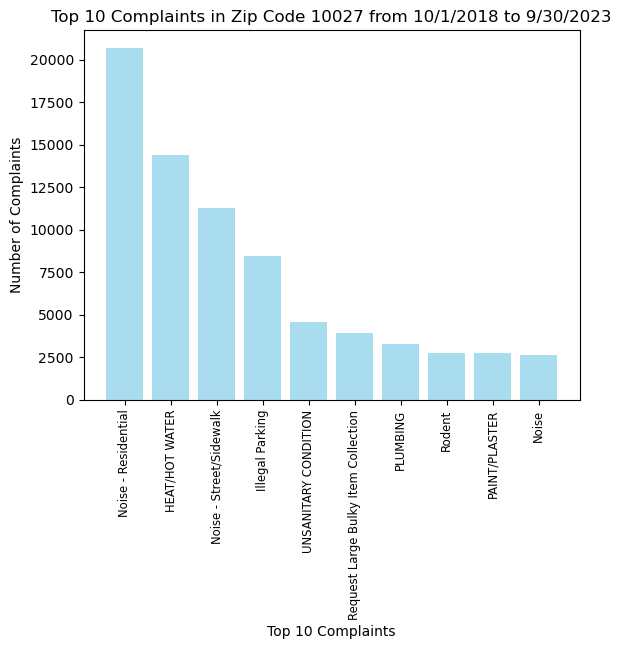

In [76]:
df_visual2 = get_data_for_visual_2()
plot_visual_2(df_visual2)

### Visualization 3

In [77]:
def get_data_for_visual_3():
    """ 
    Write a query to get data from database for Visualization 3 and return to a dataframe.
    """
    
    QUERY_Visual3 = """
        SELECT 
            rents.zip_code,
            ROUND(CAST(rents.mean AS numeric),2) as rent,
            zipcode_trees.num_trees, 
            zipcode_complaints.num_complaints
        FROM rents
        JOIN 
            (SELECT zip_code, COUNT(*) as num_trees
             FROM trees
             GROUP BY zip_code) 
        AS zipcode_trees 
        ON rents.zip_code = zipcode_trees.zip_code
        JOIN (SELECT zip_code, COUNT(*) as num_complaints
              FROM complaints
              GROUP BY zip_code)
        AS zipcode_complaints
        ON rents.zip_code = zipcode_complaints.zip_code
        """
    
    with engine.connect() as connection:
        df = pd.read_sql_query(QUERY_Visual3, connection)
        
    return df

In [78]:
def plot_visual_3(df):
    """Plot a scatter plot of the number of trees and complaints corresponding to rent.
    
    Keyword arguments:
    df -- a dataframe contains zipcodes and corresponding average rent, number of trees, and number of complaint
    """
    
    rent= df['rent'].tolist()
    num_trees = df['num_trees']
    num_complaints = df['num_complaints']
    
    # create the first figure
    fig, ax1 = plt.subplots()
    plt.title('Relationship Between Rents, Trees, and Complaints') 

    # draw the first scatter plot
    ax1.scatter(rent, num_trees, label='Number of Trees', color='darkgreen')
    ax1.set_xlabel('Rent($)')
    ax1.set_ylabel('Number of trees', color='darkgreen')
    ax1.tick_params(axis='y', labelcolor='darkgreen')

    # create the second figure
    ax2 = ax1.twinx()

    # draw the second scatter plot
    ax2.scatter(rent, num_complaints, label='Number of Complaints', color='red')
    ax2.set_ylabel('Number of complaints', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')

    plt.show()

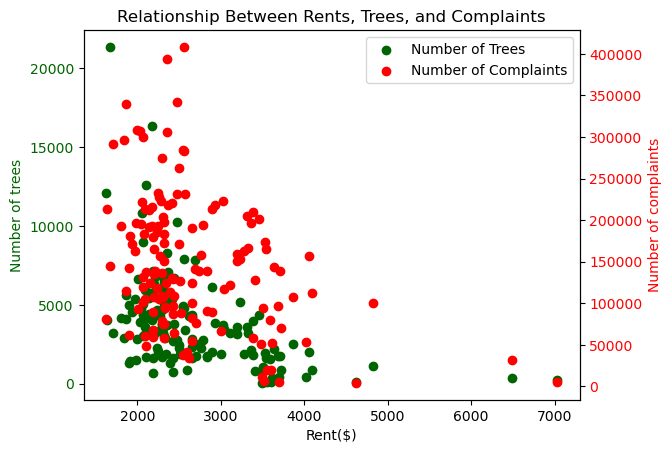

In [79]:
df_visual3 = get_data_for_visual_3()
plot_visual_3(df_visual3)

### Visualization 4

In [80]:
def get_data_for_visual_4():
    """ 
    Write a query to get data from database for Visualization 4 and return to a dataframe.
    """
    
    QUERY_Visual4 = """
        SELECT 
            rents.zip_code,
            ROUND(CAST(september2023 AS numeric),2) as rent,
            complaints_zipcode.num_complaints
        FROM(
            SELECT zip_code, COUNT(*) AS num_complaints
            FROM complaints
            GROUP BY zip_code)
        AS complaints_zipcode
        JOIN rents ON complaints_zipcode.zip_code = rents.zip_code
        """
    
    with engine.connect() as connection:
        df = pd.read_sql_query(QUERY_Visual4, connection)
        
    return df

In [81]:
def plot_visual_4(df):
    """Plot a boxplot for number of 311 complaints in each zipcode by rent.
    
    Keyword arguments:
    df -- a dataframe contains zipcodes and corresponding average rent and number of complaint
    """
    
    # Create bins for average rent in September 2023
    bins = list(range(0, 9001, 1000))  # Creating bins in $1000 increments up to $9,000

    # Bin the average rent data
    df['rent_bin'] = pd.cut(df['rent'], bins=bins, labels=bins[:-1])
    
    group_rent = df.groupby('rent_bin')['num_complaints'].apply(list).reset_index(name='num_complaints')
    group_dict = group_rent.set_index('rent_bin')['num_complaints'].to_dict()
    
    # Create a boxplot
    plt.figure(figsize=(8,6))
    plt.boxplot([group_dict[bin_val] for bin_val in bins[:-1]], labels=[f'${bin_val}-{bin_val+1000}' for bin_val in bins[:-1]])
    plt.title('Number of 311 Complaints vs. Average Rent in September 2023')
    plt.xlabel('Average Rent in September 2023')
    plt.ylabel('Number of 311 Complaints')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


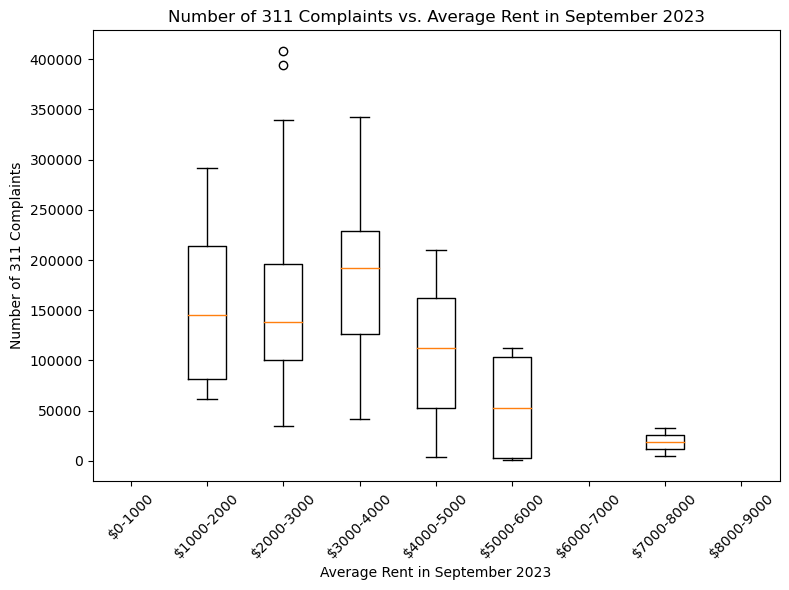

In [82]:
df_visual4 = get_data_for_visual_4()
plot_visual_4(df_visual4)

### Visualization 5

In [83]:
def get_data_for_visual_5():
    """ 
    Write a query to get data from database for Visualization 5 and return to a dataframe.
    """
    
    QUERY_Visual5 = f"""
        SELECT geometry as geom
        FROM complaints
        WHERE (created_date BETWEEN '2023-01-01' AND '2023-09-30')
        AND
            ST_DistanceSphere(
            ST_GeomFromText('POINT({longitude} {latitude})',4326),
            geometry) < 1000
        """
    
    with engine.connect() as connection:
        gdf = gpd.read_postgis(QUERY_Visual5, connection)
        
    return gdf


In [84]:
def plot_visual_5(df):
    """Plot the location of 311 incidents reported within 1 kilometer radius of Columbia campus within timeframe
    
    Keyword arguments:
    df -- a dataframe contains location of the trees satisfies the requirements
    """
    
    # Plot the incidents and the buffered area on a map
    figure, axes = plt.subplots(figsize=(20, 10))

    # Plot incidents within the buffered area
    df.plot(ax=axes, marker='o', color='red', markersize=5, label='Complaints within 1km radius')

    plt.title('Reported 311 Incidents within 1km of campus')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    
    plt.show()

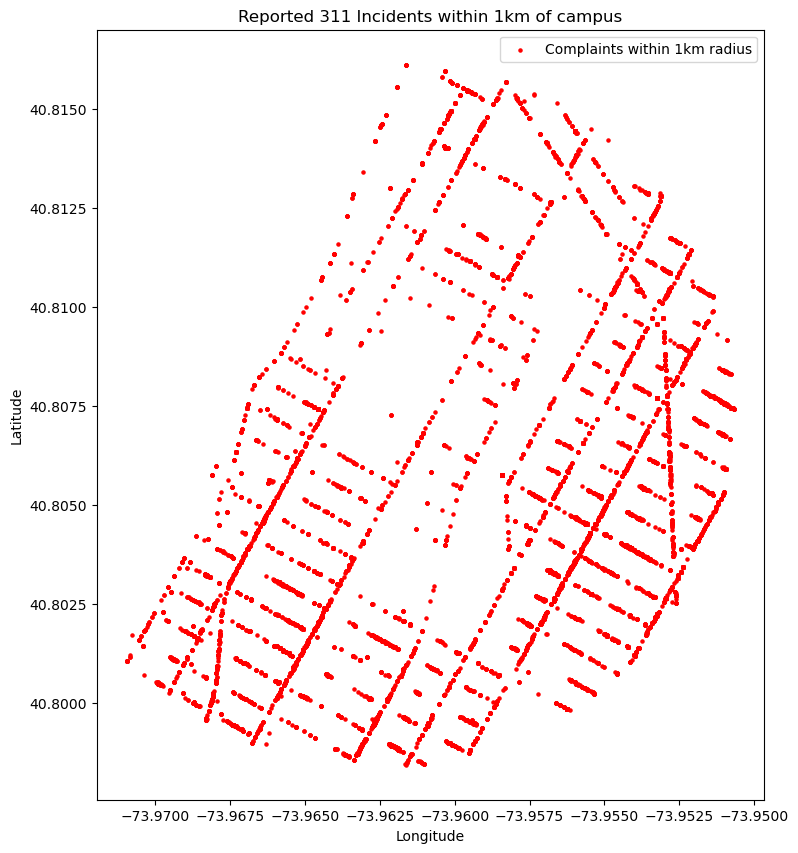

In [85]:
df_visual5 = get_data_for_visual_5()
plot_visual_5(df_visual5)

### Visualization 6

In [86]:
def tree_data_for_visual_6():
    """ 
    Write a query to get tree data from database for Visualization 6 and return to a dataframe.
    """
    
    TREE_Visual6 = """
        SELECT geometry as geom
        FROM trees
        """
    
    with engine.connect() as connection:
        gdf = gpd.read_postgis(TREE_Visual6, connection)
        
    return gdf

def complaint_data_for_visual_6():
    """ 
    Write a query to get complaint data from database for Visualization 6 and return to a dataframe.
    """
    
    COMPLAINT_Visual6 = """
        SELECT geometry as geom
        FROM complaints
        WHERE (created_date BETWEEN'2018-10-01'AND '2023-09-30')
        AND complaint_type = 'New Tree Request'
        """
    
    with engine.connect() as connection:
        gdf = gpd.read_postgis(COMPLAINT_Visual6, connection)
        
    return gdf

In [97]:
def plot_visual_6(tree, request):
    """Plot the location of trees and request for new trees in NYC.
    
    Keyword arguments:
    tree -- a dataframe contains the location of each trees in NYC
    request -- a dataframe contains the locations of 311 requests for new trees in NYC
    """
    
    # Plotting
    figure, axes = plt.subplots(figsize=(20, 10))

    # Plot trees
    tree.plot(ax=axes, marker='o', color='green', markersize=5, label='Trees')

    # Plot 311 requests
    request.plot(ax=axes, marker='^', color='wheat', markersize=5, label='Requests for more trees')

    # Add basemap of NYC (if available)
    # Set titles and labels
    plt.title('Tree Coordinates vs. New Tree Request 311 Complaints in NYC')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()

    # Show plot
    plt.show()

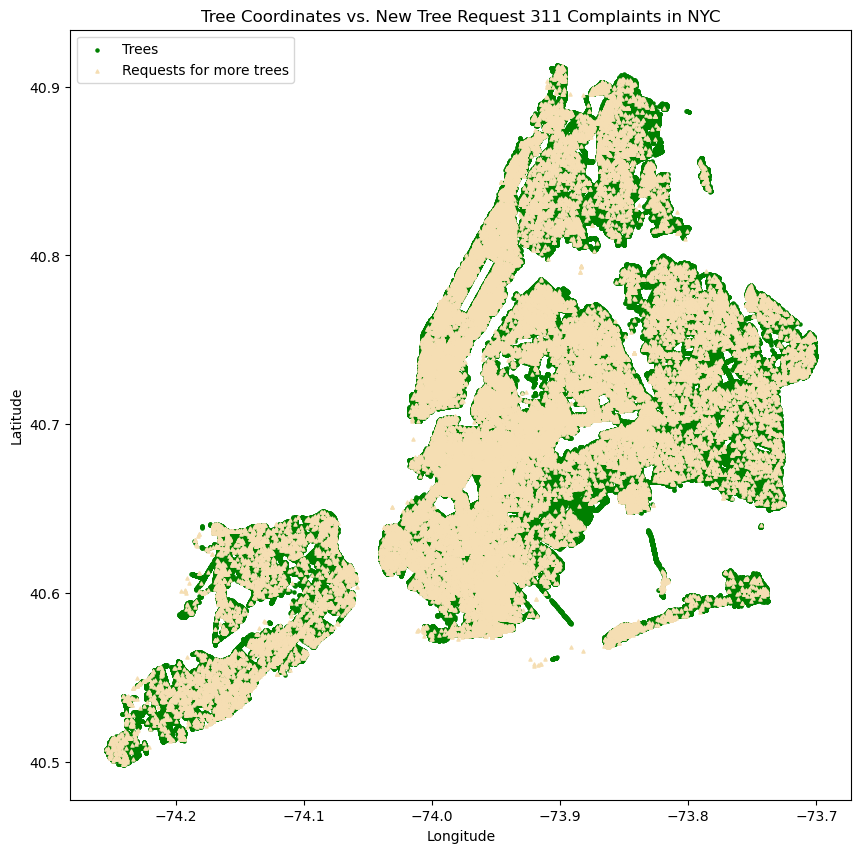

In [98]:
df_tree_visual6 = tree_data_for_visual_6()
df_complaint_visual6 = complaint_data_for_visual_6()
plot_visual_6(df_tree_visual6, df_complaint_visual6)